In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

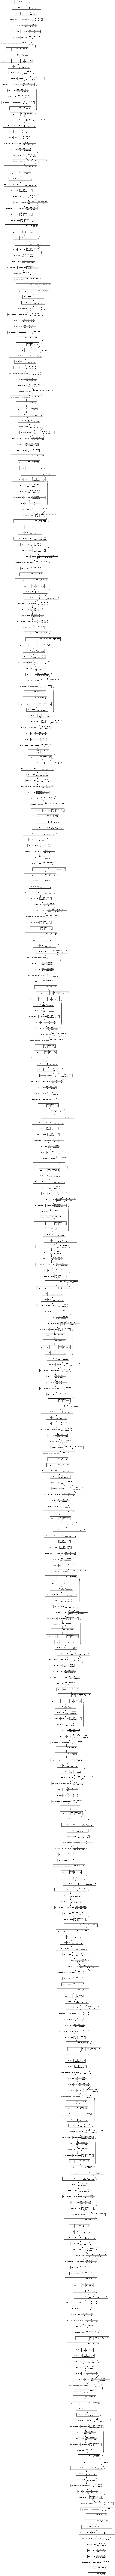

In [47]:
# https://amaarora.github.io/2020/08/02/densenets.html
def dense_net(initial_feature, num_label, input_shape, 
              dense_block_config, drop_out = 0.2, bottle_necksz=4, growth_rate=32):
    
    def dense_block(input_layer, num_sets, bottle_necksz, growth_rate):
        layer_sets = [input_layer]
        for i in range(num_sets):
            if i > 0:
                input_layer = keras.layers.Concatenate()(layer_sets)
                layer_sets = []
                layer_sets.append(input_layer)
            bottleneck_1 = keras.layers.BatchNormalization()(input_layer)
            activation_1 = keras.layers.ReLU()(bottleneck_1)
            convolution_1 = keras.layers.Conv2D(bottle_necksz*growth_rate,
                                                kernel_size=(1,1), strides=1, use_bias=False)(activation_1)
            bottleneck_2 = keras.layers.BatchNormalization()(convolution_1)
            activation_2 =  keras.layers.ReLU()(bottleneck_2)
            convolution_2 = keras.layers.Conv2D(growth_rate, kernel_size=(3,3), 
                                                strides=1, padding='same', use_bias=False)(activation_2)
            layer_sets.append(convolution_2)
        return keras.layers.Concatenate()(layer_sets)

    def transition_layer(input_layer):
        batch_norm = keras.layers.BatchNormalization()(input_layer)
        activation = keras.layers.ReLU()(batch_norm)
        feature_size = keras.backend.int_shape(activation)[3]
        conv = keras.layers.Conv2D(feature_size//2, kernel_size=(1,1),strides=1,use_bias=False)(activation)
        pool = keras.layers.AveragePooling2D()(conv)
        return pool

    def fully_connected_layer(input_layer, num_labels):
        pool = keras.layers.GlobalAveragePooling2D()(input_layer)
        norm_1 = keras.layers.BatchNormalization()(pool)
        dropout = keras.layers.Dropout(.2)(norm_1)
        dense_1 = keras.layers.Dense(1024, activation='relu')(dropout)
        dense_2 = keras.layers.Dense(512, activation='relu')(dense_1)
        norm_2 = keras.layers.BatchNormalization()(dense_2)
        dropout_2 = keras.layers.Dropout(.2)(norm_2)
        return keras.layers.Dense(num_labels, activation='softmax')(dropout_2)

    inputs = keras.Input(shape = input_shape)
    # initial transition layers
    initial_padding_1 = keras.layers.ZeroPadding2D(padding=(3,3))(inputs)
    initial_conv = keras.layers.Conv2D(initial_feature, kernel_size=(7,7), 
                                       strides=2, use_bias=False)(initial_padding_1)
    initial_norm = keras.layers.BatchNormalization()(initial_conv)
    initial_relu = keras.layers.ReLU()(initial_norm)
    initial_padding_2 = keras.layers.ZeroPadding2D(padding=(1,1))(initial_relu)
    initial = keras.layers.MaxPooling2D(pool_size=(3,3), strides=2)(initial_padding_2)
    
    for num in dense_block_config:
        conv = dense_block(initial, num, bottle_necksz, growth_rate)
        initial = transition_layer(conv)

    outputs = fully_connected_layer(initial, num_label)
    return keras.Model(inputs=inputs, outputs=outputs)

    
model = dense_net(64, 15, (128, 126, 3), (6, 12, 24, 16))
keras.utils.plot_model(model, "coded_model.png", show_shapes=True)


In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 126, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 132, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 63, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 63, 64)  256         ['conv2d[0][0]']             

In [9]:
import pandas as pd

manifest = pd.read_csv("sample_set\\01_manifest.csv")

,filename,package_hash,manual_tag,tag_set,category_set
0,101729-0-0-1.wav,u8k_fold9,air_conditioner,{'air_conditioner'},{'mechanical'}
1,103249-5-0-1.wav,u8k_fold9,engine_idling,{'engine_idling'},{'transport_car'}
2,104817-4-0-11.wav,u8k_fold2,drilling,{'drilling'},{'mechanical_construction'}
3,104998-7-16-0.wav,u8k_fold5,jackhammer,{'jackhammer'},{'mechanical_construction'}
4,104998-7-18-3.wav,u8k_fold5,jackhammer,{'jackhammer'},{'mechanical_construction'}


In [10]:
from sklearn.preprocessing import MultiLabelBinarizer
final_categories = ["animal_dogs", "animal_insects", "animal_birds", "animal_cockatoo", "animal_poultry",  "background","human_voice",  "indeterminate","mechanical", "mechanical_construction", "mechanical_impulsive","nature_wind", "signals_horn", "signals_siren", "transport_car"]
category_encoder = MultiLabelBinarizer().fit([final_categories])
category_encoder.classes_

array(['animal_birds', 'animal_cockatoo', 'animal_dogs', 'animal_insects',
       'animal_poultry', 'background', 'human_voice', 'indeterminate',
       'mechanical', 'mechanical_construction', 'mechanical_impulsive',
       'nature_wind', 'signals_horn', 'signals_siren', 'transport_car'],
      dtype=object)

In [11]:
# These spectrogram settings look pretty good from a domain perspective.
# Trying a little bit higher "resolution" than previously
mel_settings = {'fmax': 8000, 'power': 2, 'n_mels' :128, 'n_fft':2048, 'hop_length':512}

In [13]:
import os
import numpy as np
import soundfile as sf
import librosa
import librosa.display
import sklearn
def get_mels(filepath='', data=[], fs=-1):
    if filepath:
        data, fs = sf.read(filepath)
    else:
        assert (len(data>0) and fs >0), 'Must provide either a filename, or array of data and sample rate'
    
    S = librosa.feature.melspectrogram(y=data, 
                                   sr = fs, **mel_settings)
    return S, fs
 
def load_mels(filepath, force_create=False, save=True):
    mel_path = filepath.with_suffix('.npy')
    
    if mel_path.is_file() and not force_create:
        print('Loading {}'.format(mel_path))
        mels = np.load(mel_path)
    else:
        print('Generating from {}'.format(filepath))
        mels, _ = get_mels(filepath)
        if save:
            print('Saving {}'.format(mel_path))
            np.save(mel_path, mels)
    
    return mels

def feature_preprocessing(mel):
    # convert to db and normalise
    power = librosa.core.power_to_db(mel, ref=np.max)
    power = power - np.mean(power)
    power = power / (np.std(power))
    return power[:, :, None]

In [29]:
# generate the features
# note this will store all features in memory, as well as saving them to disk. 
# Can't guarantee it will work for large datasets.
manifest['features'] = manifest.apply(lambda x: data_root/x['package_hash']/x['filename'], axis=1).apply(lambda x: feature_preprocessing(load_mels(x, force_create=True, save=True)))

Generating from sample_set\u8k_fold9\101729-0-0-1.wav
Saving sample_set\u8k_fold9\101729-0-0-1.npy
Generating from sample_set\u8k_fold9\103249-5-0-1.wav
Saving sample_set\u8k_fold9\103249-5-0-1.npy
Generating from sample_set\u8k_fold2\104817-4-0-11.wav
Saving sample_set\u8k_fold2\104817-4-0-11.npy
Generating from sample_set\u8k_fold5\104998-7-16-0.wav
Saving sample_set\u8k_fold5\104998-7-16-0.npy
Generating from sample_set\u8k_fold5\104998-7-18-3.wav
Saving sample_set\u8k_fold5\104998-7-18-3.npy
Generating from sample_set\u8k_fold5\104998-7-19-0.wav
Saving sample_set\u8k_fold5\104998-7-19-0.npy
Generating from sample_set\u8k_fold9\105029-7-2-4.wav
Saving sample_set\u8k_fold9\105029-7-2-4.npy
Generating from sample_set\u8k_fold6\107842-4-2-4.wav
Saving sample_set\u8k_fold6\107842-4-2-4.npy
Generating from sample_set\u8k_fold6\111386-5-1-0.wav
Saving sample_set\u8k_fold6\111386-5-1-0.npy
Generating from sample_set\u8k_fold8\113202-5-0-13.wav
Saving sample_set\u8k_fold8\113202-5-0-13.npy


Generating from sample_set\648_cnnmodel_20190221_verification_package\2019-02-04 18_39_56.wav
Saving sample_set\648_cnnmodel_20190221_verification_package\2019-02-04 18_39_56.npy
Generating from sample_set\648_cnnmodel_20190221_verification_package\2019-02-04 18_53_20.wav
Saving sample_set\648_cnnmodel_20190221_verification_package\2019-02-04 18_53_20.npy
Generating from sample_set\639_cnnmodel_20190218_verification_package\2019-02-04 19_09_23.wav
Saving sample_set\639_cnnmodel_20190218_verification_package\2019-02-04 19_09_23.npy
Generating from sample_set\648_cnnmodel_retrain_20190226_verification_package\2019-02-04 19_21_13.wav
Saving sample_set\648_cnnmodel_retrain_20190226_verification_package\2019-02-04 19_21_13.npy
Generating from sample_set\644_reatrain_20190220_verification_package\2019-02-05 18_00_46.wav
Saving sample_set\644_reatrain_20190220_verification_package\2019-02-05 18_00_46.npy
Generating from sample_set\644_reatrain_20190220_verification_package\2019-02-05 18_51_59

Generating from sample_set\635_cnnmodel_20190220_verification_package_subset\2019-02-19 19_35_54.wav
Saving sample_set\635_cnnmodel_20190220_verification_package_subset\2019-02-19 19_35_54.npy
Generating from sample_set\635_cnnmodel_20190220_verification_package_subset\2019-02-19 19_36_58.wav
Saving sample_set\635_cnnmodel_20190220_verification_package_subset\2019-02-19 19_36_58.npy
Generating from sample_set\635_cnnmodel_20190220_verification_package\2019-02-19 19_42_58.wav
Saving sample_set\635_cnnmodel_20190220_verification_package\2019-02-19 19_42_58.npy
Generating from sample_set\635_cnnmodel_20190220_verification_package\2019-02-19 19_47_09.wav
Saving sample_set\635_cnnmodel_20190220_verification_package\2019-02-19 19_47_09.npy
Generating from sample_set\635_cnnmodel_20190220_verification_package_subset\2019-02-19 19_50_53.wav
Saving sample_set\635_cnnmodel_20190220_verification_package_subset\2019-02-19 19_50_53.npy
Generating from sample_set\635_cnnmodel_20190220_verification_p

Generating from sample_set\rvsu\2019-03-19 15_33_45.wav
Saving sample_set\rvsu\2019-03-19 15_33_45.npy
Generating from sample_set\llkw\2019-03-19 20_04_02.wav
Saving sample_set\llkw\2019-03-19 20_04_02.npy
Generating from sample_set\llkw\2019-03-19 20_24_42.wav
Saving sample_set\llkw\2019-03-19 20_24_42.npy
Generating from sample_set\llkw\2019-03-19 20_26_10.wav
Saving sample_set\llkw\2019-03-19 20_26_10.npy
Generating from sample_set\llkw\2019-03-19 20_36_40.wav
Saving sample_set\llkw\2019-03-19 20_36_40.npy
Generating from sample_set\zsdx\2019-03-22 22_27_50.wav
Saving sample_set\zsdx\2019-03-22 22_27_50.npy
Generating from sample_set\kgcz\2019-03-23 08_28_54.wav
Saving sample_set\kgcz\2019-03-23 08_28_54.npy
Generating from sample_set\kgcz\2019-03-23 08_32_46.wav
Saving sample_set\kgcz\2019-03-23 08_32_46.npy
Generating from sample_set\kgcz\2019-03-23 08_45_36.wav
Saving sample_set\kgcz\2019-03-23 08_45_36.npy
Generating from sample_set\llkw\2019-03-23 19_00_07.wav
Saving sample_set

Generating from sample_set\btzj\2019-04-05 22_02_40.wav
Saving sample_set\btzj\2019-04-05 22_02_40.npy
Generating from sample_set\btzj\2019-04-06 02_47_19.wav
Saving sample_set\btzj\2019-04-06 02_47_19.npy
Generating from sample_set\btzj\2019-04-06 02_50_21.wav
Saving sample_set\btzj\2019-04-06 02_50_21.npy
Generating from sample_set\shyz\2019-04-06 13_17_48.wav
Saving sample_set\shyz\2019-04-06 13_17_48.npy
Generating from sample_set\surd\2019-04-07 14_08_39.wav
Saving sample_set\surd\2019-04-07 14_08_39.npy
Generating from sample_set\surd\2019-04-07 14_59_40.wav
Saving sample_set\surd\2019-04-07 14_59_40.npy
Generating from sample_set\shyz\2019-04-08 12_08_48.wav
Saving sample_set\shyz\2019-04-08 12_08_48.npy
Generating from sample_set\surd\2019-04-09 20_16_39.wav
Saving sample_set\surd\2019-04-09 20_16_39.npy
Generating from sample_set\surd\2019-04-09 20_54_49.wav
Saving sample_set\surd\2019-04-09 20_54_49.npy
Generating from sample_set\surd\2019-04-09 20_54_53.wav
Saving sample_set

Generating from sample_set\othe\2019-05-10 16_43_54.wav
Saving sample_set\othe\2019-05-10 16_43_54.npy
Generating from sample_set\yaza\2019-05-10 20_42_26.wav
Saving sample_set\yaza\2019-05-10 20_42_26.npy
Generating from sample_set\nbwo_1\2019-05-12 13_09_37.wav
Saving sample_set\nbwo_1\2019-05-12 13_09_37.npy
Generating from sample_set\yaza\2019-05-12 19_15_23.wav
Saving sample_set\yaza\2019-05-12 19_15_23.npy
Generating from sample_set\yaza\2019-05-12 19_21_35.wav
Saving sample_set\yaza\2019-05-12 19_21_35.npy
Generating from sample_set\yaza\2019-05-12 19_53_25.wav
Saving sample_set\yaza\2019-05-12 19_53_25.npy
Generating from sample_set\yaza\2019-05-12 19_56_01.wav
Saving sample_set\yaza\2019-05-12 19_56_01.npy
Generating from sample_set\aslw\2019-05-12 20_12_57.wav
Saving sample_set\aslw\2019-05-12 20_12_57.npy
Generating from sample_set\aslw\2019-05-12 20_57_51.wav
Saving sample_set\aslw\2019-05-12 20_57_51.npy
Generating from sample_set\aslw\2019-05-12 21_10_57.wav
Saving sample

Generating from sample_set\vmhs\2019-05-21 13_33_10.wav
Saving sample_set\vmhs\2019-05-21 13_33_10.npy
Generating from sample_set\vmhs\2019-05-21 13_37_08.wav
Saving sample_set\vmhs\2019-05-21 13_37_08.npy
Generating from sample_set\vmhs\2019-05-22 12_23_10.wav
Saving sample_set\vmhs\2019-05-22 12_23_10.npy
Generating from sample_set\vmhs\2019-05-22 12_59_35.wav
Saving sample_set\vmhs\2019-05-22 12_59_35.npy
Generating from sample_set\drvi\2019-05-22 19_10_07.wav
Saving sample_set\drvi\2019-05-22 19_10_07.npy
Generating from sample_set\wdoy\2019-05-23 09_42_26.wav
Saving sample_set\wdoy\2019-05-23 09_42_26.npy
Generating from sample_set\wdoy\2019-05-23 09_49_40.wav
Saving sample_set\wdoy\2019-05-23 09_49_40.npy
Generating from sample_set\wdoy\2019-05-23 09_57_04.wav
Saving sample_set\wdoy\2019-05-23 09_57_04.npy
Generating from sample_set\ekwe\2019-05-23 10_06_47.wav
Saving sample_set\ekwe\2019-05-23 10_06_47.npy
Generating from sample_set\nflm\2019-05-23 19_29_56.wav
Saving sample_set

Generating from sample_set\cciz\2019-06-01 16_09_59.wav
Saving sample_set\cciz\2019-06-01 16_09_59.npy
Generating from sample_set\cciz\2019-06-01 16_18_39.wav
Saving sample_set\cciz\2019-06-01 16_18_39.npy
Generating from sample_set\dzlg\2019-06-01 16_28_26.wav
Saving sample_set\dzlg\2019-06-01 16_28_26.npy
Generating from sample_set\cciz\2019-06-01 16_28_30.wav
Saving sample_set\cciz\2019-06-01 16_28_30.npy
Generating from sample_set\tlow\2019-06-01 19_11_48.wav
Saving sample_set\tlow\2019-06-01 19_11_48.npy
Generating from sample_set\tlow\2019-06-01 19_12_14.wav
Saving sample_set\tlow\2019-06-01 19_12_14.npy
Generating from sample_set\mhyf\2019-06-01 19_19_20.wav
Saving sample_set\mhyf\2019-06-01 19_19_20.npy
Generating from sample_set\tlow\2019-06-01 19_44_23.wav
Saving sample_set\tlow\2019-06-01 19_44_23.npy
Generating from sample_set\tlow\2019-06-01 19_51_27.wav
Saving sample_set\tlow\2019-06-01 19_51_27.npy
Generating from sample_set\krlj\2019-06-01 20_06_14.wav
Saving sample_set

Generating from sample_set\lqnk\2019-06-14 22_28_21.wav
Saving sample_set\lqnk\2019-06-14 22_28_21.npy
Generating from sample_set\oryf\2019-06-14 23_09_50.wav
Saving sample_set\oryf\2019-06-14 23_09_50.npy
Generating from sample_set\oryf\2019-06-14 23_15_26.wav
Saving sample_set\oryf\2019-06-14 23_15_26.npy
Generating from sample_set\oryf\2019-06-14 23_22_48.wav
Saving sample_set\oryf\2019-06-14 23_22_48.npy
Generating from sample_set\oryf\2019-06-14 23_33_21.wav
Saving sample_set\oryf\2019-06-14 23_33_21.npy
Generating from sample_set\fqiw\2019-06-14 23_50_37.wav
Saving sample_set\fqiw\2019-06-14 23_50_37.npy
Generating from sample_set\oryf\2019-06-14 23_51_25.wav
Saving sample_set\oryf\2019-06-14 23_51_25.npy
Generating from sample_set\fqiw\2019-06-18 18_29_21.wav
Saving sample_set\fqiw\2019-06-18 18_29_21.npy
Generating from sample_set\fqiw\2019-06-18 18_45_03.wav
Saving sample_set\fqiw\2019-06-18 18_45_03.npy
Generating from sample_set\fqiw\2019-06-18 18_57_22.wav
Saving sample_set

Generating from sample_set\geik\2019-07-08 08_20_37.wav
Saving sample_set\geik\2019-07-08 08_20_37.npy
Generating from sample_set\geik\2019-07-08 08_24_47.wav
Saving sample_set\geik\2019-07-08 08_24_47.npy
Generating from sample_set\geik\2019-07-08 08_25_34.wav
Saving sample_set\geik\2019-07-08 08_25_34.npy
Generating from sample_set\geik\2019-07-08 08_33_33.wav
Saving sample_set\geik\2019-07-08 08_33_33.npy
Generating from sample_set\geik\2019-07-08 08_41_38.wav
Saving sample_set\geik\2019-07-08 08_41_38.npy
Generating from sample_set\izmh\2019-07-08 16_34_31.wav
Saving sample_set\izmh\2019-07-08 16_34_31.npy
Generating from sample_set\izmh\2019-07-08 16_36_59.wav
Saving sample_set\izmh\2019-07-08 16_36_59.npy
Generating from sample_set\glxl\2019-07-08 16_43_36.wav
Saving sample_set\glxl\2019-07-08 16_43_36.npy
Generating from sample_set\glxl\2019-07-08 16_47_24.wav
Saving sample_set\glxl\2019-07-08 16_47_24.npy
Generating from sample_set\izmh\2019-07-08 16_59_01.wav
Saving sample_set

Generating from sample_set\jozd\2019-07-24 17_14_42.wav
Saving sample_set\jozd\2019-07-24 17_14_42.npy
Generating from sample_set\gcrs\2019-07-24 17_27_03.wav
Saving sample_set\gcrs\2019-07-24 17_27_03.npy
Generating from sample_set\jozd\2019-07-24 17_34_45.wav
Saving sample_set\jozd\2019-07-24 17_34_45.npy
Generating from sample_set\gcrs\2019-07-24 17_41_11.wav
Saving sample_set\gcrs\2019-07-24 17_41_11.npy
Generating from sample_set\jozd\2019-07-24 17_42_03.wav
Saving sample_set\jozd\2019-07-24 17_42_03.npy
Generating from sample_set\gcrs\2019-07-24 17_44_11.wav
Saving sample_set\gcrs\2019-07-24 17_44_11.npy
Generating from sample_set\gcrs\2019-07-24 17_47_27.wav
Saving sample_set\gcrs\2019-07-24 17_47_27.npy
Generating from sample_set\gcrs\2019-07-24 17_49_15.wav
Saving sample_set\gcrs\2019-07-24 17_49_15.npy
Generating from sample_set\jozd\2019-07-24 17_59_42.wav
Saving sample_set\jozd\2019-07-24 17_59_42.npy
Generating from sample_set\bzzw\2019-07-25 08_11_36.wav
Saving sample_set

Generating from sample_set\rlzn\2019-08-24 22_38_22.wav
Saving sample_set\rlzn\2019-08-24 22_38_22.npy
Generating from sample_set\rlzn\2019-08-24 22_59_13.wav
Saving sample_set\rlzn\2019-08-24 22_59_13.npy
Generating from sample_set\ewfc\2019-08-25 04_26_13.wav
Saving sample_set\ewfc\2019-08-25 04_26_13.npy
Generating from sample_set\ewfc\2019-08-25 04_40_40.wav
Saving sample_set\ewfc\2019-08-25 04_40_40.npy
Generating from sample_set\wrqb\2019-08-26 20_32_22.wav
Saving sample_set\wrqb\2019-08-26 20_32_22.npy
Generating from sample_set\wrqb\2019-08-26 20_36_48.wav
Saving sample_set\wrqb\2019-08-26 20_36_48.npy
Generating from sample_set\wrqb\2019-08-26 20_45_10.wav
Saving sample_set\wrqb\2019-08-26 20_45_10.npy
Generating from sample_set\ewfc\2019-08-28 00_22_08.wav
Saving sample_set\ewfc\2019-08-28 00_22_08.npy
Generating from sample_set\ogqm\2019-08-28 00_22_48.wav
Saving sample_set\ogqm\2019-08-28 00_22_48.npy
Generating from sample_set\ewfc\2019-08-28 00_26_36.wav
Saving sample_set

Generating from sample_set\pptm\2019-09-08 21_27_40.wav
Saving sample_set\pptm\2019-09-08 21_27_40.npy
Generating from sample_set\rvud\2019-09-08 21_28_16.wav
Saving sample_set\rvud\2019-09-08 21_28_16.npy
Generating from sample_set\pptm\2019-09-08 21_34_42.wav
Saving sample_set\pptm\2019-09-08 21_34_42.npy
Generating from sample_set\pptm\2019-09-10 08_14_48.wav
Saving sample_set\pptm\2019-09-10 08_14_48.npy
Generating from sample_set\pptm\2019-09-10 08_23_42.wav
Saving sample_set\pptm\2019-09-10 08_23_42.npy
Generating from sample_set\pptm\2019-09-10 08_25_18.wav
Saving sample_set\pptm\2019-09-10 08_25_18.npy
Generating from sample_set\pptm\2019-09-10 08_31_23.wav
Saving sample_set\pptm\2019-09-10 08_31_23.npy
Generating from sample_set\pptm\2019-09-10 08_32_51.wav
Saving sample_set\pptm\2019-09-10 08_32_51.npy
Generating from sample_set\pptm\2019-09-10 08_40_11.wav
Saving sample_set\pptm\2019-09-10 08_40_11.npy
Generating from sample_set\pptm\2019-09-10 08_58_19.wav
Saving sample_set

Generating from sample_set\ksah\2019-09-27 20_59_03.wav
Saving sample_set\ksah\2019-09-27 20_59_03.npy
Generating from sample_set\ksah\2019-09-27 21_36_40.wav
Saving sample_set\ksah\2019-09-27 21_36_40.npy
Generating from sample_set\ksah\2019-09-27 21_40_14.wav
Saving sample_set\ksah\2019-09-27 21_40_14.npy
Generating from sample_set\bowt\2019-09-27T11_32_14+1000.wav
Saving sample_set\bowt\2019-09-27T11_32_14+1000.npy
Generating from sample_set\bowt\2019-09-27T15_56_55+1000.wav
Saving sample_set\bowt\2019-09-27T15_56_55+1000.npy
Generating from sample_set\bowt\2019-09-27T23_13_52+1000.wav
Saving sample_set\bowt\2019-09-27T23_13_52+1000.npy
Generating from sample_set\bowt\2019-09-27T23_24_06+1000.wav
Saving sample_set\bowt\2019-09-27T23_24_06+1000.npy
Generating from sample_set\ksah\2019-09-28 20_33_44.wav
Saving sample_set\ksah\2019-09-28 20_33_44.npy
Generating from sample_set\ksah\2019-09-28 20_57_07.wav
Saving sample_set\ksah\2019-09-28 20_57_07.npy
Generating from sample_set\lsjc\2

Generating from sample_set\wscn\2019-10-13 10_49_10.wav
Saving sample_set\wscn\2019-10-13 10_49_10.npy
Generating from sample_set\wscn\2019-10-13 10_55_26.wav
Saving sample_set\wscn\2019-10-13 10_55_26.npy
Generating from sample_set\wscn\2019-10-13 10_55_34.wav
Saving sample_set\wscn\2019-10-13 10_55_34.npy
Generating from sample_set\eeuo\2019-10-14 23_28_19.wav
Saving sample_set\eeuo\2019-10-14 23_28_19.npy
Generating from sample_set\eeuo\2019-10-14 23_31_05.wav
Saving sample_set\eeuo\2019-10-14 23_31_05.npy
Generating from sample_set\eeuo\2019-10-14 23_33_13.wav
Saving sample_set\eeuo\2019-10-14 23_33_13.npy
Generating from sample_set\bhfb\2019-10-14T10_56_54+1030.wav
Saving sample_set\bhfb\2019-10-14T10_56_54+1030.npy
Generating from sample_set\gjse\2019-10-14T17_06_22+1030.wav
Saving sample_set\gjse\2019-10-14T17_06_22+1030.npy
Generating from sample_set\eeuo\2019-10-15 00_14_31.wav
Saving sample_set\eeuo\2019-10-15 00_14_31.npy
Generating from sample_set\eeuo\2019-10-15 00_31_07.w

Generating from sample_set\obhy\2019-11-02T23_28_51+1000.wav
Saving sample_set\obhy\2019-11-02T23_28_51+1000.npy
Generating from sample_set\seql\2019-11-03T00_26_55+1000.wav
Saving sample_set\seql\2019-11-03T00_26_55+1000.npy
Generating from sample_set\seql\2019-11-03T02_32_17+1000.wav
Saving sample_set\seql\2019-11-03T02_32_17+1000.npy
Generating from sample_set\rudg\2019-11-03T08_01_13+1000.wav
Saving sample_set\rudg\2019-11-03T08_01_13+1000.npy
Generating from sample_set\hfwb\2019-11-03T21_07_46+1100.wav
Saving sample_set\hfwb\2019-11-03T21_07_46+1100.npy
Generating from sample_set\rudg\2019-11-03T23_35_29+1000.wav
Saving sample_set\rudg\2019-11-03T23_35_29+1000.npy
Generating from sample_set\rudg\2019-11-04T00_16_38+1000.wav
Saving sample_set\rudg\2019-11-04T00_16_38+1000.npy
Generating from sample_set\rudg\2019-11-04T05_09_03+1000.wav
Saving sample_set\rudg\2019-11-04T05_09_03+1000.npy
Generating from sample_set\hfwb\2019-11-04T19_41_30+1100.wav
Saving sample_set\hfwb\2019-11-04T1

Saving sample_set\uocg\2019-11-15T11_52_42+1030.npy
Generating from sample_set\hfwb\2019-11-15T20_41_52+1100.wav
Saving sample_set\hfwb\2019-11-15T20_41_52+1100.npy
Generating from sample_set\wixh\2019-11-16T02_58_44+1030.wav
Saving sample_set\wixh\2019-11-16T02_58_44+1030.npy
Generating from sample_set\wixh\2019-11-16T08_57_08+1030.wav
Saving sample_set\wixh\2019-11-16T08_57_08+1030.npy
Generating from sample_set\wixh\2019-11-16T19_45_01+1030.wav
Saving sample_set\wixh\2019-11-16T19_45_01+1030.npy
Generating from sample_set\hfwb\2019-11-17T06_37_08+1100.wav
Saving sample_set\hfwb\2019-11-17T06_37_08+1100.npy
Generating from sample_set\wixh\2019-11-17T13_20_11+1030.wav
Saving sample_set\wixh\2019-11-17T13_20_11+1030.npy
Generating from sample_set\hfwb\2019-11-17T18_29_15+1100.wav
Saving sample_set\hfwb\2019-11-17T18_29_15+1100.npy
Generating from sample_set\hfwb\2019-11-18T07_31_26+1100.wav
Saving sample_set\hfwb\2019-11-18T07_31_26+1100.npy
Generating from sample_set\nvid\2019-11-19T0

Generating from sample_set\kxwx\2019-12-02T08_00_08+1030.wav
Saving sample_set\kxwx\2019-12-02T08_00_08+1030.npy
Generating from sample_set\kxwx\2019-12-02T09_17_18+1030.wav
Saving sample_set\kxwx\2019-12-02T09_17_18+1030.npy
Generating from sample_set\kxwx\2019-12-02T16_11_54+1030.wav
Saving sample_set\kxwx\2019-12-02T16_11_54+1030.npy
Generating from sample_set\qker\2019-12-02T17_37_29+0800.wav
Saving sample_set\qker\2019-12-02T17_37_29+0800.npy
Generating from sample_set\kxwx\2019-12-02T18_36_57+1030.wav
Saving sample_set\kxwx\2019-12-02T18_36_57+1030.npy
Generating from sample_set\spmr\2019-12-02T19_40_38+0800.wav
Saving sample_set\spmr\2019-12-02T19_40_38+0800.npy
Generating from sample_set\mdin\2019-12-02T20_45_32+0930.wav
Saving sample_set\mdin\2019-12-02T20_45_32+0930.npy
Generating from sample_set\pzul\2019-12-02T22_05_03+0930.wav
Saving sample_set\pzul\2019-12-02T22_05_03+0930.npy
Generating from sample_set\pzul\2019-12-03T04_39_05+0930.wav
Saving sample_set\pzul\2019-12-03T0

Generating from sample_set\dxyz\2019-12-09T18_09_43+1000.wav
Saving sample_set\dxyz\2019-12-09T18_09_43+1000.npy
Generating from sample_set\dxyz\2019-12-09T22_25_54+1000.wav
Saving sample_set\dxyz\2019-12-09T22_25_54+1000.npy
Generating from sample_set\dxyz\2019-12-09T23_16_15+1000.wav
Saving sample_set\dxyz\2019-12-09T23_16_15+1000.npy
Generating from sample_set\qcrq\2019-12-10T06_18_05+1000.wav
Saving sample_set\qcrq\2019-12-10T06_18_05+1000.npy
Generating from sample_set\laiw\2019-12-10T07_52_26+0930.wav
Saving sample_set\laiw\2019-12-10T07_52_26+0930.npy
Generating from sample_set\extq\2019-12-10T09_40_16+0930.wav
Saving sample_set\extq\2019-12-10T09_40_16+0930.npy
Generating from sample_set\extq\2019-12-10T10_59_17+0930.wav
Saving sample_set\extq\2019-12-10T10_59_17+0930.npy
Generating from sample_set\dxyz\2019-12-10T11_11_19+1000.wav
Saving sample_set\dxyz\2019-12-10T11_11_19+1000.npy
Generating from sample_set\ytla\2019-12-10T11_40_27+0800.wav
Saving sample_set\ytla\2019-12-10T1

Generating from sample_set\extq\2019-12-14T12_47_55+0930.wav
Saving sample_set\extq\2019-12-14T12_47_55+0930.npy
Generating from sample_set\extq\2019-12-14T12_51_31+0930.wav
Saving sample_set\extq\2019-12-14T12_51_31+0930.npy
Generating from sample_set\qcrq\2019-12-14T14_00_06+1000.wav
Saving sample_set\qcrq\2019-12-14T14_00_06+1000.npy
Generating from sample_set\ytla\2019-12-14T14_20_02+0800.wav
Saving sample_set\ytla\2019-12-14T14_20_02+0800.npy
Generating from sample_set\ytla\2019-12-14T14_46_38+0800.wav
Saving sample_set\ytla\2019-12-14T14_46_38+0800.npy
Generating from sample_set\ytla\2019-12-14T15_11_39+0800.wav
Saving sample_set\ytla\2019-12-14T15_11_39+0800.npy
Generating from sample_set\qcrq\2019-12-14T17_59_47+1000.wav
Saving sample_set\qcrq\2019-12-14T17_59_47+1000.npy
Generating from sample_set\laiw\2019-12-14T19_28_39+0930.wav
Saving sample_set\laiw\2019-12-14T19_28_39+0930.npy
Generating from sample_set\qcrq\2019-12-14T19_42_52+1000.wav
Saving sample_set\qcrq\2019-12-14T1

Saving sample_set\ytla\2019-12-22T14_42_38+0800.npy
Generating from sample_set\ytla\2019-12-23T16_24_15+0800.wav
Saving sample_set\ytla\2019-12-23T16_24_15+0800.npy
Generating from sample_set\uvsg\2019-12-23T18_34_17+0800.wav
Saving sample_set\uvsg\2019-12-23T18_34_17+0800.npy
Generating from sample_set\indg\2019-12-24T06_02_52+0800.wav
Saving sample_set\indg\2019-12-24T06_02_52+0800.npy
Generating from sample_set\ytla\2019-12-24T07_03_03+0800.wav
Saving sample_set\ytla\2019-12-24T07_03_03+0800.npy
Generating from sample_set\qkvf\2019-12-24T07_11_07+0800.wav
Saving sample_set\qkvf\2019-12-24T07_11_07+0800.npy
Generating from sample_set\ytla\2019-12-24T19_50_46+0800.wav
Saving sample_set\ytla\2019-12-24T19_50_46+0800.npy
Generating from sample_set\indg\2019-12-27T10_09_09+0800.wav
Saving sample_set\indg\2019-12-27T10_09_09+0800.npy
Generating from sample_set\indg\2019-12-28T18_35_44+0800.wav
Saving sample_set\indg\2019-12-28T18_35_44+0800.npy
Generating from sample_set\indg\2019-12-29T1

Generating from sample_set\bpnv\2020-01-30T18_00_39+0930.wav
Saving sample_set\bpnv\2020-01-30T18_00_39+0930.npy
Generating from sample_set\qrxr\2020-01-30T20_05_31+0930.wav
Saving sample_set\qrxr\2020-01-30T20_05_31+0930.npy
Generating from sample_set\bpnv\2020-01-31T05_37_12+0930.wav
Saving sample_set\bpnv\2020-01-31T05_37_12+0930.npy
Generating from sample_set\czbj\2020-01-31T10_55_01+0930.wav
Saving sample_set\czbj\2020-01-31T10_55_01+0930.npy
Generating from sample_set\qrxr\2020-01-31T14_50_24+0930.wav
Saving sample_set\qrxr\2020-01-31T14_50_24+0930.npy
Generating from sample_set\bpnv\2020-01-31T16_21_30+0930.wav
Saving sample_set\bpnv\2020-01-31T16_21_30+0930.npy
Generating from sample_set\bpnv\2020-01-31T18_45_28+0930.wav
Saving sample_set\bpnv\2020-01-31T18_45_28+0930.npy
Generating from sample_set\bpnv\2020-01-31T18_52_28+0930.wav
Saving sample_set\bpnv\2020-01-31T18_52_28+0930.npy
Generating from sample_set\qctc\2020-01-31T20_02_21+0930.wav
Saving sample_set\qctc\2020-01-31T2

Generating from sample_set\cuxv\2020-02-11T09_40_44+0930.wav
Saving sample_set\cuxv\2020-02-11T09_40_44+0930.npy
Generating from sample_set\olrl\2020-02-11T14_14_09+0930.wav
Saving sample_set\olrl\2020-02-11T14_14_09+0930.npy
Generating from sample_set\syhj\2020-02-11T14_15_40+0800.wav
Saving sample_set\syhj\2020-02-11T14_15_40+0800.npy
Generating from sample_set\syhj\2020-02-12T04_24_17+0800.wav
Saving sample_set\syhj\2020-02-12T04_24_17+0800.npy
Generating from sample_set\cuxv\2020-02-12T05_42_16+0930.wav
Saving sample_set\cuxv\2020-02-12T05_42_16+0930.npy
Generating from sample_set\cuxv\2020-02-12T10_16_18+0930.wav
Saving sample_set\cuxv\2020-02-12T10_16_18+0930.npy
Generating from sample_set\olrl\2020-02-12T14_18_31+0930.wav
Saving sample_set\olrl\2020-02-12T14_18_31+0930.npy
Generating from sample_set\cuxv\2020-02-12T21_21_27+0930.wav
Saving sample_set\cuxv\2020-02-12T21_21_27+0930.npy
Generating from sample_set\olrl\2020-02-13T08_23_27+0930.wav
Saving sample_set\olrl\2020-02-13T0

Generating from sample_set\jofc\2020-02-22T10_14_44+1000.wav
Saving sample_set\jofc\2020-02-22T10_14_44+1000.npy
Generating from sample_set\uieh\2020-02-22T15_43_45+1030.wav
Saving sample_set\uieh\2020-02-22T15_43_45+1030.npy
Generating from sample_set\uieh\2020-02-22T16_03_33+1030.wav
Saving sample_set\uieh\2020-02-22T16_03_33+1030.npy
Generating from sample_set\uieh\2020-02-22T18_41_20+1030.wav
Saving sample_set\uieh\2020-02-22T18_41_20+1030.npy
Generating from sample_set\yrbx\2020-02-22T18_49_56+1030.wav
Saving sample_set\yrbx\2020-02-22T18_49_56+1030.npy
Generating from sample_set\widu\2020-02-22T18_53_48+1030.wav
Saving sample_set\widu\2020-02-22T18_53_48+1030.npy
Generating from sample_set\uieh\2020-02-22T19_09_40+1030.wav
Saving sample_set\uieh\2020-02-22T19_09_40+1030.npy
Generating from sample_set\widu\2020-02-22T19_16_20+1030.wav
Saving sample_set\widu\2020-02-22T19_16_20+1030.npy
Generating from sample_set\yrbx\2020-02-22T19_34_01+1030.wav
Saving sample_set\yrbx\2020-02-22T1

Generating from sample_set\grig\2020-03-03T16_36_39+0800.wav
Saving sample_set\grig\2020-03-03T16_36_39+0800.npy
Generating from sample_set\qmcl\2020-03-04T08_52_05+0800.wav
Saving sample_set\qmcl\2020-03-04T08_52_05+0800.npy
Generating from sample_set\grig\2020-03-04T08_59_29+0800.wav
Saving sample_set\grig\2020-03-04T08_59_29+0800.npy
Generating from sample_set\grig\2020-03-04T11_05_15+0800.wav
Saving sample_set\grig\2020-03-04T11_05_15+0800.npy
Generating from sample_set\ezag\2020-03-04T16_15_28+0800.wav
Saving sample_set\ezag\2020-03-04T16_15_28+0800.npy
Generating from sample_set\jofc\2020-03-04T16_37_21+1000.wav
Saving sample_set\jofc\2020-03-04T16_37_21+1000.npy
Generating from sample_set\ezag\2020-03-04T17_50_58+0800.wav
Saving sample_set\ezag\2020-03-04T17_50_58+0800.npy
Generating from sample_set\jofc\2020-03-04T18_41_20+1000.wav
Saving sample_set\jofc\2020-03-04T18_41_20+1000.npy
Generating from sample_set\qmcl\2020-03-04T18_46_19+0800.wav
Saving sample_set\qmcl\2020-03-04T1

Generating from sample_set\grig\2020-03-12T05_45_58+0800.wav
Saving sample_set\grig\2020-03-12T05_45_58+0800.npy
Generating from sample_set\akne\2020-03-12T13_26_30+1030.wav
Saving sample_set\akne\2020-03-12T13_26_30+1030.npy
Generating from sample_set\bctb\2020-03-12T16_14_08+1000.wav
Saving sample_set\bctb\2020-03-12T16_14_08+1000.npy
Generating from sample_set\deot\2020-03-12T17_42_41+1000.wav
Saving sample_set\deot\2020-03-12T17_42_41+1000.npy
Generating from sample_set\deot\2020-03-12T18_33_18+1000.wav
Saving sample_set\deot\2020-03-12T18_33_18+1000.npy
Generating from sample_set\akne\2020-03-12T18_40_12+1030.wav
Saving sample_set\akne\2020-03-12T18_40_12+1030.npy
Generating from sample_set\akne\2020-03-12T19_42_49+1030.wav
Saving sample_set\akne\2020-03-12T19_42_49+1030.npy
Generating from sample_set\xeii\2020-03-13T00_31_41+1000.wav
Saving sample_set\xeii\2020-03-13T00_31_41+1000.npy
Generating from sample_set\deot\2020-03-13T07_09_04+1000.wav
Saving sample_set\deot\2020-03-13T0

Generating from sample_set\tgbg\2020-03-17T16_51_17+0930.wav
Saving sample_set\tgbg\2020-03-17T16_51_17+0930.npy
Generating from sample_set\tgbg\2020-03-17T18_05_15+0930.wav
Saving sample_set\tgbg\2020-03-17T18_05_15+0930.npy
Generating from sample_set\akne\2020-03-17T18_33_58+1030.wav
Saving sample_set\akne\2020-03-17T18_33_58+1030.npy
Generating from sample_set\deot\2020-03-17T20_03_41+1000.wav
Saving sample_set\deot\2020-03-17T20_03_41+1000.npy
Generating from sample_set\tgbg\2020-03-17T20_59_47+0930.wav
Saving sample_set\tgbg\2020-03-17T20_59_47+0930.npy
Generating from sample_set\tgbg\2020-03-18T01_45_25+0930.wav
Saving sample_set\tgbg\2020-03-18T01_45_25+0930.npy
Generating from sample_set\deot\2020-03-18T04_38_12+1000.wav
Saving sample_set\deot\2020-03-18T04_38_12+1000.npy
Generating from sample_set\bctb\2020-03-18T04_48_36+1000.wav
Saving sample_set\bctb\2020-03-18T04_48_36+1000.npy
Generating from sample_set\bctb\2020-03-18T05_43_45+1000.wav
Saving sample_set\bctb\2020-03-18T0

Saving sample_set\amoq\2020-03-22T05_05_37+0930.npy
Generating from sample_set\tgbg\2020-03-22T06_14_42+0930.wav
Saving sample_set\tgbg\2020-03-22T06_14_42+0930.npy
Generating from sample_set\amoq\2020-03-22T06_52_47+0930.wav
Saving sample_set\amoq\2020-03-22T06_52_47+0930.npy
Generating from sample_set\amoq\2020-03-22T06_53_27+0930.wav
Saving sample_set\amoq\2020-03-22T06_53_27+0930.npy
Generating from sample_set\amoq\2020-03-22T11_06_42+0930.wav
Saving sample_set\amoq\2020-03-22T11_06_42+0930.npy
Generating from sample_set\fbhp\2020-03-22T12_37_03+1030.wav
Saving sample_set\fbhp\2020-03-22T12_37_03+1030.npy
Generating from sample_set\qamh\2020-03-22T15_47_31+0930.wav
Saving sample_set\qamh\2020-03-22T15_47_31+0930.npy
Generating from sample_set\fbhp\2020-03-22T18_33_47+1030.wav
Saving sample_set\fbhp\2020-03-22T18_33_47+1030.npy
Generating from sample_set\hujv\2020-03-22T20_07_16+0930.wav
Saving sample_set\hujv\2020-03-22T20_07_16+0930.npy
Generating from sample_set\qamh\2020-03-22T2

Generating from sample_set\iqvu\2020-03-29T16_42_57+1000.wav
Saving sample_set\iqvu\2020-03-29T16_42_57+1000.npy
Generating from sample_set\trxn\2020-03-29T17_14_15+1000.wav
Saving sample_set\trxn\2020-03-29T17_14_15+1000.npy
Generating from sample_set\laon\2020-03-29T18_02_48+1000.wav
Saving sample_set\laon\2020-03-29T18_02_48+1000.npy
Generating from sample_set\laon\2020-03-29T23_48_50+1000.wav
Saving sample_set\laon\2020-03-29T23_48_50+1000.npy
Generating from sample_set\trxn\2020-03-30T00_51_07+1000.wav
Saving sample_set\trxn\2020-03-30T00_51_07+1000.npy
Generating from sample_set\ewhc\2020-03-30T01_24_40+1000.wav
Saving sample_set\ewhc\2020-03-30T01_24_40+1000.npy
Generating from sample_set\fbhp\2020-03-30T08_59_40+1030.wav
Saving sample_set\fbhp\2020-03-30T08_59_40+1030.npy
Generating from sample_set\fbhp\2020-03-30T09_51_10+1030.wav
Saving sample_set\fbhp\2020-03-30T09_51_10+1030.npy
Generating from sample_set\ewhc\2020-03-30T10_47_24+1000.wav
Saving sample_set\ewhc\2020-03-30T1

Generating from sample_set\pgzf\2020-05-06T20_15_02+1000.wav
Saving sample_set\pgzf\2020-05-06T20_15_02+1000.npy
Generating from sample_set\yawu\2020-05-07T07_46_29+0930.wav
Saving sample_set\yawu\2020-05-07T07_46_29+0930.npy
Generating from sample_set\lasn\2020-05-07T08_19_21+1000.wav
Saving sample_set\lasn\2020-05-07T08_19_21+1000.npy
Generating from sample_set\yawu\2020-05-07T10_57_57+0930.wav
Saving sample_set\yawu\2020-05-07T10_57_57+0930.npy
Generating from sample_set\pgzf\2020-05-07T11_42_00+1000.wav
Saving sample_set\pgzf\2020-05-07T11_42_00+1000.npy
Generating from sample_set\qrcg\2020-05-07T12_14_58+1000.wav
Saving sample_set\qrcg\2020-05-07T12_14_58+1000.npy
Generating from sample_set\dlzh\2020-05-07T12_56_20+0930.wav
Saving sample_set\dlzh\2020-05-07T12_56_20+0930.npy
Generating from sample_set\lasn\2020-05-07T17_30_48+1000.wav
Saving sample_set\lasn\2020-05-07T17_30_48+1000.npy
Generating from sample_set\qrcg\2020-05-07T21_00_42+1000.wav
Saving sample_set\qrcg\2020-05-07T2

Saving sample_set\kxoj\2020-05-16T00_58_44+1000.npy
Generating from sample_set\yawu\2020-05-16T11_01_03+0930.wav
Saving sample_set\yawu\2020-05-16T11_01_03+0930.npy
Generating from sample_set\kxoj\2020-05-16T17_21_44+1000.wav
Saving sample_set\kxoj\2020-05-16T17_21_44+1000.npy
Generating from sample_set\yawu\2020-05-16T17_47_21+0930.wav
Saving sample_set\yawu\2020-05-16T17_47_21+0930.npy
Generating from sample_set\yawu\2020-05-17T06_07_27+0930.wav
Saving sample_set\yawu\2020-05-17T06_07_27+0930.npy
Generating from sample_set\dlzh\2020-05-17T23_10_54+0930.wav
Saving sample_set\dlzh\2020-05-17T23_10_54+0930.npy
Generating from sample_set\yawu\2020-05-18T11_34_03+0930.wav
Saving sample_set\yawu\2020-05-18T11_34_03+0930.npy
Generating from sample_set\yawu\2020-05-18T17_50_56+0930.wav
Saving sample_set\yawu\2020-05-18T17_50_56+0930.npy
Generating from sample_set\kxoj\2020-05-19T06_53_52+1000.wav
Saving sample_set\kxoj\2020-05-19T06_53_52+1000.npy
Generating from sample_set\dlzh\2020-05-19T0

Generating from sample_set\nghb\2020-06-21T11_36_23+0930.wav
Saving sample_set\nghb\2020-06-21T11_36_23+0930.npy
Generating from sample_set\nghb\2020-06-21T13_00_29+0930.wav
Saving sample_set\nghb\2020-06-21T13_00_29+0930.npy
Generating from sample_set\xsuh\2020-06-21T20_32_55+0930.wav
Saving sample_set\xsuh\2020-06-21T20_32_55+0930.npy
Generating from sample_set\arwl\2020-06-22T14_47_14+0930.wav
Saving sample_set\arwl\2020-06-22T14_47_14+0930.npy
Generating from sample_set\nghb\2020-06-22T16_22_51+0930.wav
Saving sample_set\nghb\2020-06-22T16_22_51+0930.npy
Generating from sample_set\xsuh\2020-06-22T17_32_39+0930.wav
Saving sample_set\xsuh\2020-06-22T17_32_39+0930.npy
Generating from sample_set\xsuh\2020-06-22T17_51_23+0930.wav
Saving sample_set\xsuh\2020-06-22T17_51_23+0930.npy
Generating from sample_set\arwl\2020-06-23T07_37_47+0930.wav
Saving sample_set\arwl\2020-06-23T07_37_47+0930.npy
Generating from sample_set\nghb\2020-06-23T10_25_11+0930.wav
Saving sample_set\nghb\2020-06-23T1

Generating from sample_set\ujsy\2020-07-04T13_46_07+1000.wav
Saving sample_set\ujsy\2020-07-04T13_46_07+1000.npy
Generating from sample_set\ujsy\2020-07-04T15_27_13+1000.wav
Saving sample_set\ujsy\2020-07-04T15_27_13+1000.npy
Generating from sample_set\arwl\2020-07-04T16_14_53+0930.wav
Saving sample_set\arwl\2020-07-04T16_14_53+0930.npy
Generating from sample_set\nzvs\2020-07-04T18_27_35+1000.wav
Saving sample_set\nzvs\2020-07-04T18_27_35+1000.npy
Generating from sample_set\mdyk\2020-07-04T19_59_40+0930.wav
Saving sample_set\mdyk\2020-07-04T19_59_40+0930.npy
Generating from sample_set\nzvs\2020-07-05T05_46_32+1000.wav
Saving sample_set\nzvs\2020-07-05T05_46_32+1000.npy
Generating from sample_set\arwl\2020-07-05T10_10_33+0930.wav
Saving sample_set\arwl\2020-07-05T10_10_33+0930.npy
Generating from sample_set\ujsy\2020-07-05T14_56_51+1000.wav
Saving sample_set\ujsy\2020-07-05T14_56_51+1000.npy
Generating from sample_set\ujsy\2020-07-05T16_19_12+1000.wav
Saving sample_set\ujsy\2020-07-05T1

Generating from sample_set\biwa\2020-07-11T17_41_21+1000.wav
Saving sample_set\biwa\2020-07-11T17_41_21+1000.npy
Generating from sample_set\wutt\2020-07-11T18_36_59+1000.wav
Saving sample_set\wutt\2020-07-11T18_36_59+1000.npy
Generating from sample_set\mdyk\2020-07-11T19_36_04+0930.wav
Saving sample_set\mdyk\2020-07-11T19_36_04+0930.npy
Generating from sample_set\yxue\2020-07-12T01_20_57+0930.wav
Saving sample_set\yxue\2020-07-12T01_20_57+0930.npy
Generating from sample_set\jbyx\2020-07-12T02_42_46+0930.wav
Saving sample_set\jbyx\2020-07-12T02_42_46+0930.npy
Generating from sample_set\wutt\2020-07-12T05_33_09+1000.wav
Saving sample_set\wutt\2020-07-12T05_33_09+1000.npy
Generating from sample_set\biwa\2020-07-12T07_11_00+1000.wav
Saving sample_set\biwa\2020-07-12T07_11_00+1000.npy
Generating from sample_set\yxue\2020-07-12T14_53_43+0930.wav
Saving sample_set\yxue\2020-07-12T14_53_43+0930.npy
Generating from sample_set\mdyk\2020-07-12T18_12_33+0930.wav
Saving sample_set\mdyk\2020-07-12T1

Saving sample_set\ukbw\2020-07-22T15_54_37+1000.npy
Generating from sample_set\ukbw\2020-07-22T18_28_12+1000.wav
Saving sample_set\ukbw\2020-07-22T18_28_12+1000.npy
Generating from sample_set\ukbw\2020-07-23T12_33_45+1000.wav
Saving sample_set\ukbw\2020-07-23T12_33_45+1000.npy
Generating from sample_set\ukbw\2020-07-24T02_01_22+1000.wav
Saving sample_set\ukbw\2020-07-24T02_01_22+1000.npy
Generating from sample_set\ukbw\2020-07-24T16_56_27+1000.wav
Saving sample_set\ukbw\2020-07-24T16_56_27+1000.npy
Generating from sample_set\yusw\2020-07-24T17_13_30+1000.wav
Saving sample_set\yusw\2020-07-24T17_13_30+1000.npy
Generating from sample_set\ukbw\2020-07-24T22_04_38+1000.wav
Saving sample_set\ukbw\2020-07-24T22_04_38+1000.npy
Generating from sample_set\ukbw\2020-07-25T06_32_28+1000.wav
Saving sample_set\ukbw\2020-07-25T06_32_28+1000.npy
Generating from sample_set\yusw\2020-07-25T19_16_26+1000.wav
Saving sample_set\yusw\2020-07-25T19_16_26+1000.npy
Generating from sample_set\ukbw\2020-07-26T0

Generating from sample_set\ygpr\2020-08-19T02_21_37+0930.wav
Saving sample_set\ygpr\2020-08-19T02_21_37+0930.npy
Generating from sample_set\ygpr\2020-08-19T18_08_14+0930.wav
Saving sample_set\ygpr\2020-08-19T18_08_14+0930.npy
Generating from sample_set\inxu\2020-08-21T11_16_08+0930.wav
Saving sample_set\inxu\2020-08-21T11_16_08+0930.npy
Generating from sample_set\inxu\2020-08-21T11_50_01+0930.wav
Saving sample_set\inxu\2020-08-21T11_50_01+0930.npy
Generating from sample_set\avwy\2020-08-21T18_00_43+0930.wav
Saving sample_set\avwy\2020-08-21T18_00_43+0930.npy
Generating from sample_set\inxu\2020-08-21T18_57_29+0930.wav
Saving sample_set\inxu\2020-08-21T18_57_29+0930.npy
Generating from sample_set\avwy\2020-08-21T23_46_41+0930.wav
Saving sample_set\avwy\2020-08-21T23_46_41+0930.npy
Generating from sample_set\ygpr\2020-08-22T02_11_26+0930.wav
Saving sample_set\ygpr\2020-08-22T02_11_26+0930.npy
Generating from sample_set\demx\2020-08-22T07_31_44+0930.wav
Saving sample_set\demx\2020-08-22T0

Saving sample_set\qllj\2020-09-08T16_42_51+0800.npy
Generating from sample_set\dbga\2020-09-08T17_57_32+0930.wav
Saving sample_set\dbga\2020-09-08T17_57_32+0930.npy
Generating from sample_set\qllj\2020-09-08T18_23_22+0800.wav
Saving sample_set\qllj\2020-09-08T18_23_22+0800.npy
Generating from sample_set\jmkq\2020-09-09T00_28_05+0930.wav
Saving sample_set\jmkq\2020-09-09T00_28_05+0930.npy
Generating from sample_set\izvu\2020-09-09T18_19_40+1000.wav
Saving sample_set\izvu\2020-09-09T18_19_40+1000.npy
Generating from sample_set\ilpo\2020-09-10T01_58_57+0930.wav
Saving sample_set\ilpo\2020-09-10T01_58_57+0930.npy
Generating from sample_set\qllj\2020-09-10T10_16_53+0800.wav
Saving sample_set\qllj\2020-09-10T10_16_53+0800.npy
Generating from sample_set\lenc\2020-09-10T10_47_51+0930.wav
Saving sample_set\lenc\2020-09-10T10_47_51+0930.npy
Generating from sample_set\jmkq\2020-09-10T10_56_20+0930.wav
Saving sample_set\jmkq\2020-09-10T10_56_20+0930.npy
Generating from sample_set\dfpt\2020-09-10T1

Generating from sample_set\jrgj\2020-09-24T08_27_40+0930.wav
Saving sample_set\jrgj\2020-09-24T08_27_40+0930.npy
Generating from sample_set\pzby\2020-09-24T08_44_57+1000.wav
Saving sample_set\pzby\2020-09-24T08_44_57+1000.npy
Generating from sample_set\eoya\2020-09-24T08_51_44+1000.wav
Saving sample_set\eoya\2020-09-24T08_51_44+1000.npy
Generating from sample_set\tjhe\2020-09-24T12_43_44+1000.wav
Saving sample_set\tjhe\2020-09-24T12_43_44+1000.npy
Generating from sample_set\jrgj\2020-09-24T15_24_13+0930.wav
Saving sample_set\jrgj\2020-09-24T15_24_13+0930.npy
Generating from sample_set\rqvf\2020-09-24T20_01_48+0800.wav
Saving sample_set\rqvf\2020-09-24T20_01_48+0800.npy
Generating from sample_set\jrgj\2020-09-24T20_08_06+0930.wav
Saving sample_set\jrgj\2020-09-24T20_08_06+0930.npy
Generating from sample_set\xfwe\2020-09-24T21_49_22+1000.wav
Saving sample_set\xfwe\2020-09-24T21_49_22+1000.npy
Generating from sample_set\teox\2020-09-24T21_59_58+1000.wav
Saving sample_set\teox\2020-09-24T2

Generating from sample_set\wjts\2020-10-10T11_35_29+0930.wav
Saving sample_set\wjts\2020-10-10T11_35_29+0930.npy
Generating from sample_set\gmhf\2020-10-10T12_08_04+1030.wav
Saving sample_set\gmhf\2020-10-10T12_08_04+1030.npy
Generating from sample_set\neeo\2020-10-10T17_33_40+0930.wav
Saving sample_set\neeo\2020-10-10T17_33_40+0930.npy
Generating from sample_set\gmhf\2020-10-10T20_22_04+1030.wav
Saving sample_set\gmhf\2020-10-10T20_22_04+1030.npy
Generating from sample_set\neeo\2020-10-11T06_43_46+0930.wav
Saving sample_set\neeo\2020-10-11T06_43_46+0930.npy
Generating from sample_set\srmu\2020-10-11T09_06_28+1100.wav
Saving sample_set\srmu\2020-10-11T09_06_28+1100.npy
Generating from sample_set\gmhf\2020-10-11T10_19_11+1030.wav
Saving sample_set\gmhf\2020-10-11T10_19_11+1030.npy
Generating from sample_set\gmhf\2020-10-11T11_04_04+1030.wav
Saving sample_set\gmhf\2020-10-11T11_04_04+1030.npy
Generating from sample_set\neeo\2020-10-11T19_58_37+0930.wav
Saving sample_set\neeo\2020-10-11T1

Generating from sample_set\dvjr\2020-10-19T07_42_48+1000.wav
Saving sample_set\dvjr\2020-10-19T07_42_48+1000.npy
Generating from sample_set\hhqq\2020-10-19T09_14_59+1030.wav
Saving sample_set\hhqq\2020-10-19T09_14_59+1030.npy
Generating from sample_set\dvjr\2020-10-19T09_38_06+1000.wav
Saving sample_set\dvjr\2020-10-19T09_38_06+1000.npy
Generating from sample_set\dvjr\2020-10-19T12_40_30+1000.wav
Saving sample_set\dvjr\2020-10-19T12_40_30+1000.npy
Generating from sample_set\pfzp\2020-10-19T18_07_18+1000.wav
Saving sample_set\pfzp\2020-10-19T18_07_18+1000.npy
Generating from sample_set\neeo\2020-10-19T19_34_38+0930.wav
Saving sample_set\neeo\2020-10-19T19_34_38+0930.npy
Generating from sample_set\dvjr\2020-10-19T20_56_48+1000.wav
Saving sample_set\dvjr\2020-10-19T20_56_48+1000.npy
Generating from sample_set\eqcg\2020-10-20T03_41_59+0800.wav
Saving sample_set\eqcg\2020-10-20T03_41_59+0800.npy
Generating from sample_set\dvjr\2020-10-20T16_44_31+1000.wav
Saving sample_set\dvjr\2020-10-20T1

Saving sample_set\sbvt\2020-11-03T18_13_12+0930.npy
Generating from sample_set\uusr\2020-11-03T19_47_42+0930.wav
Saving sample_set\uusr\2020-11-03T19_47_42+0930.npy
Generating from sample_set\sbvt\2020-11-03T20_04_39+0930.wav
Saving sample_set\sbvt\2020-11-03T20_04_39+0930.npy
Generating from sample_set\sbvt\2020-11-03T21_47_00+0930.wav
Saving sample_set\sbvt\2020-11-03T21_47_00+0930.npy
Generating from sample_set\sbvt\2020-11-04T07_27_51+0930.wav
Saving sample_set\sbvt\2020-11-04T07_27_51+0930.npy
Generating from sample_set\uusr\2020-11-04T07_30_03+0930.wav
Saving sample_set\uusr\2020-11-04T07_30_03+0930.npy
Generating from sample_set\hhqq\2020-11-04T10_58_50+1030.wav
Saving sample_set\hhqq\2020-11-04T10_58_50+1030.npy
Generating from sample_set\zsry\2020-11-04T14_50_32+1100.wav
Saving sample_set\zsry\2020-11-04T14_50_32+1100.npy
Generating from sample_set\sbvt\2020-11-04T19_15_56+0930.wav
Saving sample_set\sbvt\2020-11-04T19_15_56+0930.npy
Generating from sample_set\sbvt\2020-11-04T1

Generating from sample_set\yulh\2020-11-21T18_26_07+1000.wav
Saving sample_set\yulh\2020-11-21T18_26_07+1000.npy
Generating from sample_set\pqrf\2020-11-21T18_52_50+0800.wav
Saving sample_set\pqrf\2020-11-21T18_52_50+0800.npy
Generating from sample_set\pqrf\2020-11-21T19_34_07+0800.wav
Saving sample_set\pqrf\2020-11-21T19_34_07+0800.npy
Generating from sample_set\atql\2020-11-22T01_12_28+1000.wav
Saving sample_set\atql\2020-11-22T01_12_28+1000.npy
Generating from sample_set\atql\2020-11-22T06_06_37+1000.wav
Saving sample_set\atql\2020-11-22T06_06_37+1000.npy
Generating from sample_set\yulh\2020-11-22T14_15_56+1000.wav
Saving sample_set\yulh\2020-11-22T14_15_56+1000.npy
Generating from sample_set\yulh\2020-11-23T07_30_26+1000.wav
Saving sample_set\yulh\2020-11-23T07_30_26+1000.npy
Generating from sample_set\yulh\2020-11-23T08_05_15+1000.wav
Saving sample_set\yulh\2020-11-23T08_05_15+1000.npy
Generating from sample_set\pqrf\2020-11-24T05_49_08+0800.wav
Saving sample_set\pqrf\2020-11-24T0

Generating from sample_set\wymk\2020-12-25T09_55_17+1000.wav
Saving sample_set\wymk\2020-12-25T09_55_17+1000.npy
Generating from sample_set\oxdh\2020-12-25T16_47_42+1030.wav
Saving sample_set\oxdh\2020-12-25T16_47_42+1030.npy
Generating from sample_set\yvva\2020-12-25T17_43_58+1100.wav
Saving sample_set\yvva\2020-12-25T17_43_58+1100.npy
Generating from sample_set\wymk\2020-12-25T21_08_56+1000.wav
Saving sample_set\wymk\2020-12-25T21_08_56+1000.npy
Generating from sample_set\yvva\2020-12-25T22_45_44+1100.wav
Saving sample_set\yvva\2020-12-25T22_45_44+1100.npy
Generating from sample_set\sarl\2020-12-26T07_04_51+1100.wav
Saving sample_set\sarl\2020-12-26T07_04_51+1100.npy
Generating from sample_set\dayx\2020-12-26T08_02_19+1030.wav
Saving sample_set\dayx\2020-12-26T08_02_19+1030.npy
Generating from sample_set\oxdh\2020-12-26T13_02_41+1030.wav
Saving sample_set\oxdh\2020-12-26T13_02_41+1030.npy
Generating from sample_set\wymk\2020-12-27T03_34_19+1000.wav
Saving sample_set\wymk\2020-12-27T0

Generating from sample_set\yvva\2021-01-11T06_26_33+1100.wav
Saving sample_set\yvva\2021-01-11T06_26_33+1100.npy
Generating from sample_set\ecgg\2021-01-11T10_26_39+1000.wav
Saving sample_set\ecgg\2021-01-11T10_26_39+1000.npy
Generating from sample_set\ecgg\2021-01-11T11_22_37+1000.wav
Saving sample_set\ecgg\2021-01-11T11_22_37+1000.npy
Generating from sample_set\ecgg\2021-01-11T14_23_18+1000.wav
Saving sample_set\ecgg\2021-01-11T14_23_18+1000.npy
Generating from sample_set\sxpx\2021-01-11T14_36_09+1000.wav
Saving sample_set\sxpx\2021-01-11T14_36_09+1000.npy
Generating from sample_set\sxpx\2021-01-11T17_32_28+1000.wav
Saving sample_set\sxpx\2021-01-11T17_32_28+1000.npy
Generating from sample_set\sxpx\2021-01-11T18_48_05+1000.wav
Saving sample_set\sxpx\2021-01-11T18_48_05+1000.npy
Generating from sample_set\sxpx\2021-01-11T19_29_54+1000.wav
Saving sample_set\sxpx\2021-01-11T19_29_54+1000.npy
Generating from sample_set\jgzp\2021-01-11T20_21_11+1030.wav
Saving sample_set\jgzp\2021-01-11T2

Saving sample_set\ater\2021-02-10T13_05_37+1030.npy
Generating from sample_set\umgy\2021-02-10T13_19_18+1030.wav
Saving sample_set\umgy\2021-02-10T13_19_18+1030.npy
Generating from sample_set\mvcp\2021-02-10T15_22_28+1000.wav
Saving sample_set\mvcp\2021-02-10T15_22_28+1000.npy
Generating from sample_set\mvcp\2021-02-10T20_00_39+1000.wav
Saving sample_set\mvcp\2021-02-10T20_00_39+1000.npy
Generating from sample_set\ater\2021-02-10T22_21_41+1030.wav
Saving sample_set\ater\2021-02-10T22_21_41+1030.npy
Generating from sample_set\ater\2021-02-11T04_05_19+1030.wav
Saving sample_set\ater\2021-02-11T04_05_19+1030.npy
Generating from sample_set\ater\2021-02-11T11_10_50+1030.wav
Saving sample_set\ater\2021-02-11T11_10_50+1030.npy
Generating from sample_set\itii\2021-02-11T11_31_13+1000.wav
Saving sample_set\itii\2021-02-11T11_31_13+1000.npy
Generating from sample_set\hapo\2021-02-11T16_08_21+1000.wav
Saving sample_set\hapo\2021-02-11T16_08_21+1000.npy
Generating from sample_set\itii\2021-02-11T1

Generating from sample_set\ycev\2021-04-04T00_09_16+1100.wav
Saving sample_set\ycev\2021-04-04T00_09_16+1100.npy
Generating from sample_set\ycev\2021-04-04T02_00_47+1100.wav
Saving sample_set\ycev\2021-04-04T02_00_47+1100.npy
Generating from sample_set\ycev\2021-04-04T08_58_59+1000.wav
Saving sample_set\ycev\2021-04-04T08_58_59+1000.npy
Generating from sample_set\ycev\2021-04-05T19_12_37+1000.wav
Saving sample_set\ycev\2021-04-05T19_12_37+1000.npy
Generating from sample_set\ycev\2021-04-08T08_11_26+1000.wav
Saving sample_set\ycev\2021-04-08T08_11_26+1000.npy
Generating from sample_set\xvuo\2021-04-12T18_39_44+1000.wav
Saving sample_set\xvuo\2021-04-12T18_39_44+1000.npy
Generating from sample_set\ycev\2021-04-13T04_57_06+1000.wav
Saving sample_set\ycev\2021-04-13T04_57_06+1000.npy
Generating from sample_set\xvuo\2021-04-14T13_39_36+1000.wav
Saving sample_set\xvuo\2021-04-14T13_39_36+1000.npy
Generating from sample_set\xvuo\2021-04-14T14_03_53+1000.wav
Saving sample_set\xvuo\2021-04-14T1

Generating from sample_set\gkpv\2021-05-22T06_18_18+1000.wav
Saving sample_set\gkpv\2021-05-22T06_18_18+1000.npy
Generating from sample_set\dpre\2021-05-22T14_20_54+1000.wav
Saving sample_set\dpre\2021-05-22T14_20_54+1000.npy
Generating from sample_set\cniz\2021-05-23T09_30_15+1000.wav
Saving sample_set\cniz\2021-05-23T09_30_15+1000.npy
Generating from sample_set\dpre\2021-05-23T12_23_01+1000.wav
Saving sample_set\dpre\2021-05-23T12_23_01+1000.npy
Generating from sample_set\nfch\2021-05-23T16_16_05+1000.wav
Saving sample_set\nfch\2021-05-23T16_16_05+1000.npy
Generating from sample_set\jjph\2021-05-23T19_12_56+1000.wav
Saving sample_set\jjph\2021-05-23T19_12_56+1000.npy
Generating from sample_set\nfch\2021-05-23T19_34_53+1000.wav
Saving sample_set\nfch\2021-05-23T19_34_53+1000.npy
Generating from sample_set\jjph\2021-05-23T20_11_13+1000.wav
Saving sample_set\jjph\2021-05-23T20_11_13+1000.npy
Generating from sample_set\gkpv\2021-05-24T01_19_27+1000.wav
Saving sample_set\gkpv\2021-05-24T0

Generating from sample_set\evjj\2021-06-12T19_33_50+1000.wav
Saving sample_set\evjj\2021-06-12T19_33_50+1000.npy
Generating from sample_set\evjj\2021-06-12T22_13_01+1000.wav
Saving sample_set\evjj\2021-06-12T22_13_01+1000.npy
Generating from sample_set\rwtf\2021-06-12T22_19_41+1000.wav
Saving sample_set\rwtf\2021-06-12T22_19_41+1000.npy
Generating from sample_set\zlwz\2021-06-12T22_43_30+1000.wav
Saving sample_set\zlwz\2021-06-12T22_43_30+1000.npy
Generating from sample_set\wvfm\2021-06-12T23_19_35+0930.wav
Saving sample_set\wvfm\2021-06-12T23_19_35+0930.npy
Generating from sample_set\zzai\2021-06-13T07_48_01+0930.wav
Saving sample_set\zzai\2021-06-13T07_48_01+0930.npy
Generating from sample_set\rwtf\2021-06-13T10_01_04+1000.wav
Saving sample_set\rwtf\2021-06-13T10_01_04+1000.npy
Generating from sample_set\pxzi\2021-06-13T10_07_01+1000.wav
Saving sample_set\pxzi\2021-06-13T10_07_01+1000.npy
Generating from sample_set\cfqr\2021-06-13T10_15_05+0930.wav
Saving sample_set\cfqr\2021-06-13T1

Generating from sample_set\flso\2021-06-16T08_58_55+0930.wav
Saving sample_set\flso\2021-06-16T08_58_55+0930.npy
Generating from sample_set\pxzi\2021-06-16T09_17_52+1000.wav
Saving sample_set\pxzi\2021-06-16T09_17_52+1000.npy
Generating from sample_set\xmks\2021-06-16T11_02_30+0930.wav
Saving sample_set\xmks\2021-06-16T11_02_30+0930.npy
Generating from sample_set\zzai\2021-06-16T12_01_18+0930.wav
Saving sample_set\zzai\2021-06-16T12_01_18+0930.npy
Generating from sample_set\flso\2021-06-16T12_05_58+0930.wav
Saving sample_set\flso\2021-06-16T12_05_58+0930.npy
Generating from sample_set\zlwz\2021-06-16T13_47_56+1000.wav
Saving sample_set\zlwz\2021-06-16T13_47_56+1000.npy
Generating from sample_set\evjj\2021-06-16T15_30_52+1000.wav
Saving sample_set\evjj\2021-06-16T15_30_52+1000.npy
Generating from sample_set\hrfw\2021-06-16T15_56_22+1000.wav
Saving sample_set\hrfw\2021-06-16T15_56_22+1000.npy
Generating from sample_set\zzai\2021-06-16T16_47_13+0930.wav
Saving sample_set\zzai\2021-06-16T1

Generating from sample_set\qiiv\2021-06-22T11_10_58+0800.wav
Saving sample_set\qiiv\2021-06-22T11_10_58+0800.npy
Generating from sample_set\dacl\2021-06-22T16_49_52+1000.wav
Saving sample_set\dacl\2021-06-22T16_49_52+1000.npy
Generating from sample_set\zlwz\2021-06-22T20_48_21+1000.wav
Saving sample_set\zlwz\2021-06-22T20_48_21+1000.npy
Generating from sample_set\dacl\2021-06-23T10_10_56+1000.wav
Saving sample_set\dacl\2021-06-23T10_10_56+1000.npy
Generating from sample_set\qiiv\2021-06-23T14_45_41+0800.wav
Saving sample_set\qiiv\2021-06-23T14_45_41+0800.npy
Generating from sample_set\zlwz\2021-06-23T20_42_30+1000.wav
Saving sample_set\zlwz\2021-06-23T20_42_30+1000.npy
Generating from sample_set\numo\2021-06-23T22_25_27+1000.wav
Saving sample_set\numo\2021-06-23T22_25_27+1000.npy
Generating from sample_set\xmks\2021-06-24T04_36_30+0930.wav
Saving sample_set\xmks\2021-06-24T04_36_30+0930.npy
Generating from sample_set\ntqn\2021-06-24T10_46_18+1000.wav
Saving sample_set\ntqn\2021-06-24T1

Generating from sample_set\wsut\2021-07-03T18_28_13+1000.wav
Saving sample_set\wsut\2021-07-03T18_28_13+1000.npy
Generating from sample_set\ctpb\2021-07-03T20_00_22+0930.wav
Saving sample_set\ctpb\2021-07-03T20_00_22+0930.npy
Generating from sample_set\qiiv\2021-07-04T00_21_41+0800.wav
Saving sample_set\qiiv\2021-07-04T00_21_41+0800.npy
Generating from sample_set\qiiv\2021-07-04T07_29_59+0800.wav
Saving sample_set\qiiv\2021-07-04T07_29_59+0800.npy
Generating from sample_set\ntqn\2021-07-04T07_41_16+1000.wav
Saving sample_set\ntqn\2021-07-04T07_41_16+1000.npy
Generating from sample_set\qiiv\2021-07-04T10_41_05+0800.wav
Saving sample_set\qiiv\2021-07-04T10_41_05+0800.npy
Generating from sample_set\vdwr\2021-07-04T10_44_34+0800.wav
Saving sample_set\vdwr\2021-07-04T10_44_34+0800.npy
Generating from sample_set\qiiv\2021-07-04T13_10_16+0800.wav
Saving sample_set\qiiv\2021-07-04T13_10_16+0800.npy
Generating from sample_set\zlwz\2021-07-04T17_46_21+1000.wav
Saving sample_set\zlwz\2021-07-04T1

Generating from sample_set\ascd\2021-07-18T15_44_26+1000.wav
Saving sample_set\ascd\2021-07-18T15_44_26+1000.npy
Generating from sample_set\ascd\2021-07-18T17_00_03+1000.wav
Saving sample_set\ascd\2021-07-18T17_00_03+1000.npy
Generating from sample_set\pnut\2021-07-18T18_05_48+1000.wav
Saving sample_set\pnut\2021-07-18T18_05_48+1000.npy
Generating from sample_set\ascd\2021-07-18T20_31_31+1000.wav
Saving sample_set\ascd\2021-07-18T20_31_31+1000.npy
Generating from sample_set\kufx\2021-07-18T20_43_12+0930.wav
Saving sample_set\kufx\2021-07-18T20_43_12+0930.npy
Generating from sample_set\kufx\2021-07-19T00_59_17+0930.wav
Saving sample_set\kufx\2021-07-19T00_59_17+0930.npy
Generating from sample_set\kufx\2021-07-19T04_21_41+0930.wav
Saving sample_set\kufx\2021-07-19T04_21_41+0930.npy
Generating from sample_set\iusx\2021-07-19T07_37_58+1000.wav
Saving sample_set\iusx\2021-07-19T07_37_58+1000.npy
Generating from sample_set\pnut\2021-07-19T07_40_55+1000.wav
Saving sample_set\pnut\2021-07-19T0

Generating from sample_set\ascd\2021-07-28T11_23_52+1000.wav
Saving sample_set\ascd\2021-07-28T11_23_52+1000.npy
Generating from sample_set\qwwk\2021-07-28T12_00_28+1000.wav
Saving sample_set\qwwk\2021-07-28T12_00_28+1000.npy
Generating from sample_set\ascd\2021-07-28T15_48_33+1000.wav
Saving sample_set\ascd\2021-07-28T15_48_33+1000.npy
Generating from sample_set\brho\2021-07-28T16_06_47+1000.wav
Saving sample_set\brho\2021-07-28T16_06_47+1000.npy
Generating from sample_set\wsut\2021-07-28T17_49_46+1000.wav
Saving sample_set\wsut\2021-07-28T17_49_46+1000.npy
Generating from sample_set\zahv\2021-07-28T18_10_02+1000.wav
Saving sample_set\zahv\2021-07-28T18_10_02+1000.npy
Generating from sample_set\wsut\2021-07-28T18_12_02+1000.wav
Saving sample_set\wsut\2021-07-28T18_12_02+1000.npy
Generating from sample_set\xcoz\2021-07-28T20_11_47+1000.wav
Saving sample_set\xcoz\2021-07-28T20_11_47+1000.npy
Generating from sample_set\taoh\2021-07-29T01_40_10+0800.wav
Saving sample_set\taoh\2021-07-29T0

Generating from sample_set\taoh\2021-08-12T07_14_39+0800.wav
Saving sample_set\taoh\2021-08-12T07_14_39+0800.npy
Generating from sample_set\isea\2021-08-12T13_44_57+1000.wav
Saving sample_set\isea\2021-08-12T13_44_57+1000.npy
Generating from sample_set\zahv\2021-08-12T14_00_03+1000.wav
Saving sample_set\zahv\2021-08-12T14_00_03+1000.npy
Generating from sample_set\iwjj\2021-08-12T16_55_12+0800.wav
Saving sample_set\iwjj\2021-08-12T16_55_12+0800.npy
Generating from sample_set\mwwa\2021-08-12T20_25_18+1000.wav
Saving sample_set\mwwa\2021-08-12T20_25_18+1000.npy
Generating from sample_set\fuce\2021-08-12T20_27_21+0800.wav
Saving sample_set\fuce\2021-08-12T20_27_21+0800.npy
Generating from sample_set\mwwa\2021-08-12T20_40_18+1000.wav
Saving sample_set\mwwa\2021-08-12T20_40_18+1000.npy
Generating from sample_set\iwjj\2021-08-12T20_50_02+0800.wav
Saving sample_set\iwjj\2021-08-12T20_50_02+0800.npy
Generating from sample_set\cvdy\2021-08-12T20_57_47+0800.wav
Saving sample_set\cvdy\2021-08-12T2

Generating from sample_set\wctr\2021-09-07T13_42_45+0800.wav
Saving sample_set\wctr\2021-09-07T13_42_45+0800.npy
Generating from sample_set\wctr\2021-09-07T17_02_33+0800.wav
Saving sample_set\wctr\2021-09-07T17_02_33+0800.npy
Generating from sample_set\zohq\2021-09-08T07_37_36+1000.wav
Saving sample_set\zohq\2021-09-08T07_37_36+1000.npy
Generating from sample_set\hcqp\2021-09-08T08_52_39+0800.wav
Saving sample_set\hcqp\2021-09-08T08_52_39+0800.npy
Generating from sample_set\ovta\2021-09-09T10_15_52+0930.wav
Saving sample_set\ovta\2021-09-09T10_15_52+0930.npy
Generating from sample_set\qyzc\2021-09-09T17_45_19+0800.wav
Saving sample_set\qyzc\2021-09-09T17_45_19+0800.npy
Generating from sample_set\ovta\2021-09-10T18_15_02+0930.wav
Saving sample_set\ovta\2021-09-10T18_15_02+0930.npy
Generating from sample_set\qyzc\2021-09-10T19_39_29+0800.wav
Saving sample_set\qyzc\2021-09-10T19_39_29+0800.npy
Generating from sample_set\wctr\2021-09-12T14_55_38+0800.wav
Saving sample_set\wctr\2021-09-12T1

Generating from sample_set\zmkf\2021-09-28T08_42_02+0930.wav
Saving sample_set\zmkf\2021-09-28T08_42_02+0930.npy
Generating from sample_set\ihxa\2021-09-28T15_25_29+1000.wav
Saving sample_set\ihxa\2021-09-28T15_25_29+1000.npy
Generating from sample_set\zmkf\2021-09-28T17_19_41+0930.wav
Saving sample_set\zmkf\2021-09-28T17_19_41+0930.npy
Generating from sample_set\dqsv\2021-09-28T17_56_33+1000.wav
Saving sample_set\dqsv\2021-09-28T17_56_33+1000.npy
Generating from sample_set\qyzc\2021-09-28T19_06_25+0800.wav
Saving sample_set\qyzc\2021-09-28T19_06_25+0800.npy
Generating from sample_set\ihxa\2021-09-29T02_36_21+1000.wav
Saving sample_set\ihxa\2021-09-29T02_36_21+1000.npy
Generating from sample_set\fvdv\2021-09-29T05_34_10+0930.wav
Saving sample_set\fvdv\2021-09-29T05_34_10+0930.npy
Generating from sample_set\ihxa\2021-09-29T10_37_09+1000.wav
Saving sample_set\ihxa\2021-09-29T10_37_09+1000.npy
Generating from sample_set\ihxa\2021-09-29T13_29_06+1000.wav
Saving sample_set\ihxa\2021-09-29T1

Generating from sample_set\utbe\2021-11-04T17_37_55+1000.wav
Saving sample_set\utbe\2021-11-04T17_37_55+1000.npy
Generating from sample_set\zbgw\2021-11-04T18_52_50+0930.wav
Saving sample_set\zbgw\2021-11-04T18_52_50+0930.npy
Generating from sample_set\utbe\2021-11-04T18_59_05+1000.wav
Saving sample_set\utbe\2021-11-04T18_59_05+1000.npy
Generating from sample_set\gddd\2021-11-05T00_27_48+0930.wav
Saving sample_set\gddd\2021-11-05T00_27_48+0930.npy
Generating from sample_set\dpzd\2021-11-05T01_07_28+0930.wav
Saving sample_set\dpzd\2021-11-05T01_07_28+0930.npy
Generating from sample_set\gknr\2021-11-05T08_55_32+1100.wav
Saving sample_set\gknr\2021-11-05T08_55_32+1100.npy
Generating from sample_set\gknr\2021-11-05T09_16_29+1100.wav
Saving sample_set\gknr\2021-11-05T09_16_29+1100.npy
Generating from sample_set\zbgw\2021-11-05T09_55_46+0930.wav
Saving sample_set\zbgw\2021-11-05T09_55_46+0930.npy
Generating from sample_set\gknr\2021-11-05T10_58_30+1100.wav
Saving sample_set\gknr\2021-11-05T1

Generating from sample_set\hdzo\2021-12-02T13_32_39+1000.wav
Saving sample_set\hdzo\2021-12-02T13_32_39+1000.npy
Generating from sample_set\hdzo\2021-12-02T14_07_26+1000.wav
Saving sample_set\hdzo\2021-12-02T14_07_26+1000.npy
Generating from sample_set\nttz\2021-12-02T16_19_25+1100.wav
Saving sample_set\nttz\2021-12-02T16_19_25+1100.npy
Generating from sample_set\nttz\2021-12-02T16_32_33+1100.wav
Saving sample_set\nttz\2021-12-02T16_32_33+1100.npy
Generating from sample_set\emja\2021-12-02T19_35_12+1000.wav
Saving sample_set\emja\2021-12-02T19_35_12+1000.npy
Generating from sample_set\udlz\2021-12-02T20_41_08+1000.wav
Saving sample_set\udlz\2021-12-02T20_41_08+1000.npy
Generating from sample_set\hdzo\2021-12-03T05_18_51+1000.wav
Saving sample_set\hdzo\2021-12-03T05_18_51+1000.npy
Generating from sample_set\tqtt\2021-12-03T10_31_15+1100.wav
Saving sample_set\tqtt\2021-12-03T10_31_15+1100.npy
Generating from sample_set\udlz\2021-12-03T10_35_59+1000.wav
Saving sample_set\udlz\2021-12-03T1

Saving sample_set\efsn\2021-12-13T14_32_55+1000.npy
Generating from sample_set\seuc\2021-12-14T21_57_55+1000.wav
Saving sample_set\seuc\2021-12-14T21_57_55+1000.npy
Generating from sample_set\udlz\2021-12-15T04_56_23+1000.wav
Saving sample_set\udlz\2021-12-15T04_56_23+1000.npy
Generating from sample_set\seuc\2021-12-15T14_50_46+1000.wav
Saving sample_set\seuc\2021-12-15T14_50_46+1000.npy
Generating from sample_set\udlz\2021-12-15T19_38_55+1000.wav
Saving sample_set\udlz\2021-12-15T19_38_55+1000.npy
Generating from sample_set\efsn\2021-12-16T21_44_12+1000.wav
Saving sample_set\efsn\2021-12-16T21_44_12+1000.npy
Generating from sample_set\gvoi\2021-12-17T04_56_48+1000.wav
Saving sample_set\gvoi\2021-12-17T04_56_48+1000.npy
Generating from sample_set\gomj\2021-12-17T15_05_13+1030.wav
Saving sample_set\gomj\2021-12-17T15_05_13+1030.npy
Generating from sample_set\pjbx\2021-12-18T13_59_37+1030.wav
Saving sample_set\pjbx\2021-12-18T13_59_37+1030.npy
Generating from sample_set\znxk\2021-12-18T1

Saving sample_set\dokq\2022-01-08T10_57_46+1000.npy
Generating from sample_set\jogw\2022-01-08T14_42_08+1000.wav
Saving sample_set\jogw\2022-01-08T14_42_08+1000.npy
Generating from sample_set\dokq\2022-01-09T07_44_31+1000.wav
Saving sample_set\dokq\2022-01-09T07_44_31+1000.npy
Generating from sample_set\dokq\2022-01-09T08_00_23+1000.wav
Saving sample_set\dokq\2022-01-09T08_00_23+1000.npy
Generating from sample_set\dokq\2022-01-09T09_19_31+1000.wav
Saving sample_set\dokq\2022-01-09T09_19_31+1000.npy
Generating from sample_set\bhwh\2022-01-10T18_23_13+1000.wav
Saving sample_set\bhwh\2022-01-10T18_23_13+1000.npy
Generating from sample_set\bhwh\2022-01-10T22_37_33+1000.wav
Saving sample_set\bhwh\2022-01-10T22_37_33+1000.npy
Generating from sample_set\dokq\2022-01-11T08_59_53+1000.wav
Saving sample_set\dokq\2022-01-11T08_59_53+1000.npy
Generating from sample_set\bhwh\2022-01-11T13_10_42+1000.wav
Saving sample_set\bhwh\2022-01-11T13_10_42+1000.npy
Generating from sample_set\bhwh\2022-01-11T2

Generating from sample_set\tkgr\2022-02-01T08_15_58.543441+09_30.wav
Saving sample_set\tkgr\2022-02-01T08_15_58.543441+09_30.npy
Generating from sample_set\tkgr\2022-02-01T17_42_09.759787+09_30.wav
Saving sample_set\tkgr\2022-02-01T17_42_09.759787+09_30.npy
Generating from sample_set\lshv\2022-02-01T18_23_38+0930.wav
Saving sample_set\lshv\2022-02-01T18_23_38+0930.npy
Generating from sample_set\zgvm\2022-02-01T19_48_14.301910+09_30.wav
Saving sample_set\zgvm\2022-02-01T19_48_14.301910+09_30.npy
Generating from sample_set\pnjm\2022-02-01T20_52_16+0930.wav
Saving sample_set\pnjm\2022-02-01T20_52_16+0930.npy
Generating from sample_set\ohff\2022-02-01T23_32_47.722751+09_30.wav
Saving sample_set\ohff\2022-02-01T23_32_47.722751+09_30.npy
Generating from sample_set\uift\2022-02-03T04_07_31+0930.wav
Saving sample_set\uift\2022-02-03T04_07_31+0930.npy
Generating from sample_set\eviz\2022-02-03T07_48_31+0930.wav
Saving sample_set\eviz\2022-02-03T07_48_31+0930.npy
Generating from sample_set\zgvm\

Generating from sample_set\zgvm\2022-02-14T23_24_20.941863+09_30.wav
Saving sample_set\zgvm\2022-02-14T23_24_20.941863+09_30.npy
Generating from sample_set\jogw\2022-02-15T01_07_33+1000.wav
Saving sample_set\jogw\2022-02-15T01_07_33+1000.npy
Generating from sample_set\lshv\2022-02-15T08_03_10+0930.wav
Saving sample_set\lshv\2022-02-15T08_03_10+0930.npy
Generating from sample_set\pnjm\2022-02-15T11_36_31+0930.wav
Saving sample_set\pnjm\2022-02-15T11_36_31+0930.npy
Generating from sample_set\tkgr\2022-02-15T13_02_36.854810+09_30.wav
Saving sample_set\tkgr\2022-02-15T13_02_36.854810+09_30.npy
Generating from sample_set\uift\2022-02-15T21_53_16+0930.wav
Saving sample_set\uift\2022-02-15T21_53_16+0930.npy
Generating from sample_set\ohff\2022-02-15T23_37_42.235677+09_30.wav
Saving sample_set\ohff\2022-02-15T23_37_42.235677+09_30.npy
Generating from sample_set\eviz\2022-02-15T23_53_31+0930.wav
Saving sample_set\eviz\2022-02-15T23_53_31+0930.npy
Generating from sample_set\eviz\2022-02-16T00_52

Generating from sample_set\u8k_fold7\39857-5-0-2.wav
Saving sample_set\u8k_fold7\39857-5-0-2.npy
Generating from sample_set\u8k_fold3\42117-8-0-14.wav
Saving sample_set\u8k_fold3\42117-8-0-14.npy
Generating from sample_set\u8k_fold7\44737-5-0-1.wav
Saving sample_set\u8k_fold7\44737-5-0-1.npy
Generating from sample_set\u8k_fold1\46656-6-1-0.wav
Saving sample_set\u8k_fold1\46656-6-1-0.npy
Generating from sample_set\u8k_fold10\59513-3-0-0.wav
Saving sample_set\u8k_fold10\59513-3-0-0.npy
Generating from sample_set\u8k_fold8\59595-4-0-1.wav
Saving sample_set\u8k_fold8\59595-4-0-1.npy
Generating from sample_set\u8k_fold9\66601-8-0-5.wav
Saving sample_set\u8k_fold9\66601-8-0-5.npy
Generating from sample_set\u8k_fold8\68080-7-0-0.wav
Saving sample_set\u8k_fold8\68080-7-0-0.npy
Generating from sample_set\u8k_fold4\7389-1-0-7.wav
Saving sample_set\u8k_fold4\7389-1-0-7.npy
Generating from sample_set\u8k_fold2\74507-0-0-5.wav
Saving sample_set\u8k_fold2\74507-0-0-5.npy
Generating from sample_set\u

In [39]:
manifest.iloc[5]['features'].shape

(128, 126, 1)